<a href="https://colab.research.google.com/github/sibyjackgrove/SolarPV-DER-simulation-utility/blob/master/examples/PV-DER_usage_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import classes
Import classes neccessary to define instances of the PV-DER model, events, simulation, and results.

In [1]:
from pvder.DER_wrapper import DERModel

from pvder.grid_components import Grid
from pvder.dynamic_simulation import DynamicSimulation
from pvder.simulation_events import SimulationEvents
from pvder.simulation_utilities import SimulationUtilities,SimulationResults
from pvder import utility_functions

#Import Python modules
import logging
import numpy as np
import scipy as sci
import math
import cmath
import pandas


import matplotlib as matplotlib
print('Scipy version:',sci.__version__)
print('Numpy version:',np.__version__)
print('Matplotlib version:',matplotlib.__version__)

%matplotlib inline    #To show interactive plot in the notebook cell

Scipy version: 1.4.1
Numpy version: 1.18.4
Matplotlib version: 3.1.2


## Initialize voltage (for use with loop mode)

In [2]:
logging.debug('test')
Va=164.78-124.57j
Vb=-190.96-78.26j
Vc=26.24+206.56j
Vrms = abs(Va)/math.sqrt(2)
print('Vrms:{:.2f}'.format(Vrms))
print('Va:{:.2f},Vb:{:.2f},Vc:{:.2f}'.format(Va,Vb,Vc))
print('V0:{:.2f}'.format(Va+Vb+Vc))

events1 = SimulationEvents(verbosity = 'DEBUG')
grid1 = Grid(events=events1,unbalance_ratio_b=1.0,unbalance_ratio_c=1.0)


DEBUG:SimulationEvents:-events_1:Logging level is set to:DEBUG
DEBUG:SimulationEvents:-events_1:Simulation event counters reset!


Vrms:146.07
Va:164.78-124.57j,Vb:-190.96-78.26j,Vc:26.24+206.56j
V0:0.06+3.73j


## Select options

In [3]:
STAND_ALONE = True
STEADY_STATE = True
LOOP=False

model_type = 'ThreePhaseUnbalanced' #Model type
#three phase model types: 'ThreePhaseBalanced','ThreePhaseUnbalanced','ThreePhaseUnbalancedConstantVdc'
#single phase model types: 'SinglePhase'

der_verbosity = 'DEBUG' #Logging verbosity
config_file = r'../config_der.json'
parameter1 = '250'#'50_type1'#'50','10' '50_constantVdc','50_balanced','250'

## Select model

In [4]:
if STAND_ALONE:
    PV_DER1 = DERModel(modelType=model_type,events=events1,configFile=config_file,
                       gridModel=grid1,
                       derId=parameter1,
                       standAlone = STAND_ALONE,steadyStateInitialization=STEADY_STATE)   
else:
    PV_DER1 = DERModel(modelType=model_type,events=events1,configFile=config_file,
                       Vrmsrated = Vrms,
                       gridVoltagePhaseA = Va,gridVoltagePhaseB = Vb,gridVoltagePhaseC = Vc,gridFrequency=2*math.pi*60.0,
                       derId=parameter1,
                       standAlone = STAND_ALONE,steadyStateInitialization=STEADY_STATE,
                       verbosity = der_verbosity)        
    
sim1 = DynamicSimulation(gridModel=grid1,PV_model=PV_DER1.DER_model,events = events1,verbosity = 'INFO',solverType='odeint',LOOP_MODE=LOOP) #'odeint','ode-vode-bdf'
results1 = SimulationResults(simulation = sim1,PER_UNIT=True,verbosity = 'INFO')
PV_DER1.DER_model.show_PV_DER_parameters('controller_gains')

DER configuration with ID:250 was found in ../config_der.json


INFO:SolarPVDERThreePhase:-SolarPVDERThreePhase_1:Instance created with DER parameter ID: 250; Specifications - Srated:250.0 kVA, Ppv:254.7 kW, Vrms:230.0 V, Steady state:True,LVRT Enable:True,HVRT Enable:True


----Parameters for DER with ID:250----
Current controller :
Kp_GCC:6000.000
Ki_GCC:2000.000
wp:200000.000
DC link voltage controller :
Kp_DC:-2.000
Ki_DC:-10.000
Reactive power controller :
Kp_Q:0.200
Ki_Q:10.000


## Add simulation events

In [5]:
events1.add_grid_event(0.5,0.97,0.0,60.0) #Add grid event
events1.add_solar_event(0.75,75,298.15) #Add solar event
events1.show_events() #Show events

DEBUG:SimulationEvents:-events_1:Adding new grid event at 0.50 s
DEBUG:SimulationEvents:-events_1:Adding new solar event at 0.75 s


Showing all event in events instance -events_1
Total solar events:1
Total grid events:1
t:0.500, Grid event, Grid voltage: Magnitude:0.97, Angle:0.000 V, Frequency is 60.00
t:0.750,Solar event, Solar insolation is 75.00 W/cm2, Temperature is 298.15


## Specify run time flags, simulation time, and run simulation 

In [6]:
%%time
PV_DER1.DER_model.MPPT_ENABLE=False
PV_DER1.DER_model.RAMP_ENABLE = False
PV_DER1.DER_model.VOLT_VAR_ENABLE = False
PV_DER1.DER_model.LVRT_ENABLE = False
PV_DER1.DER_model.HVRT_ENABLE = False
PV_DER1.DER_model.LFRT_ENABLE = False
PV_DER1.DER_model.DO_EXTRA_CALCULATIONS = False
PV_DER1.DER_model.use_frequency_estimate=False
sim1.jacFlag = False
sim1.DEBUG_SIMULATION = False
sim1.DEBUG_VOLTAGES = True
sim1.DEBUG_CURRENTS = True
sim1.DEBUG_POWER = False
sim1.DEBUG_CONTROLLERS  = True
sim1.DEBUG_PLL = False
sim1.PER_UNIT = True
sim1.DEBUG_SOLVER  = True
sim1.tStop = 5.0
sim1.tInc = 1/120.# 0.001
PV_DER1.DER_model._del_t_frequency_estimate = sim1.tInc 

if sim1.LOOP_MODE:
    t0 = 0.0
    dt = 0.01
    n_time_steps = 100
    Vat = Va
    Vbt = Vb
    Vct = Vc
    
    for i in range(n_time_steps):
        t_sim= [t0,t0+dt]
        sim1.run_simulation(gridVoltagePhaseA=Vat/Grid.Vbase, gridVoltagePhaseB=Vbt/Grid.Vbase, gridVoltagePhaseC=Vct/Grid.Vbase, y0=sim1.y0, t=t_sim) #[0.0,0.01]
        t0 = t_sim[-1]
else:
    sim1.run_simulation()
    
PV_DER1.DER_model.validate_model()

PV_DER1.DER_model.show_PV_DER_states('voltage')
PV_DER1.DER_model.show_PV_DER_states('current')
PV_DER1.DER_model.show_PV_DER_states('power')
PV_DER1.DER_model.show_PV_DER_states('duty cycle')

None-sim_1:Simulation started at 0.0 s and will end at 5.0 s


DEBUG:SimulationEvents:-events_1:Removing existing grid event at 0.50
DEBUG:SimulationEvents:-events_1:Adding new grid event at 0.50 s
DEBUG:SimulationEvents:-events_1:Removing existing grid event at 0.50
DEBUG:SimulationEvents:-events_1:Adding new grid event at 0.50 s
DEBUG:SimulationEvents:-events_1:Removing existing grid event at 0.50
DEBUG:SimulationEvents:-events_1:Adding new grid event at 0.50 s
DEBUG:SimulationEvents:-events_1:Removing existing grid event at 0.50
DEBUG:SimulationEvents:-events_1:Adding new grid event at 0.50 s
DEBUG:SimulationEvents:-events_1:Removing existing grid event at 0.50
DEBUG:SimulationEvents:-events_1:Adding new grid event at 0.50 s
C:\Users\splathottam\AppData\Roaming\Python\Python37\site-packages\scipy\integrate\odepack.py:251: ODEintWarning: Integration successful.
  warnings.warn(warning_msg, ODEintWarning)
DEBUG:SimulationEvents:-events_1:Simulation event counters reset!
DEBUG:SimulationEvents:-events_1:Removing existing grid event at 0.50
DEBUG:S

-SolarPVDERThreePhase_1:Time:[0.         0.00833333 0.01666667 0.025      0.03333333 0.04166667
 0.05       0.05833333 0.06666667 0.075      0.08333333 0.09166667
 0.1        0.10833333 0.11666667 0.125      0.13333333 0.14166667
 0.15       0.15833333 0.16666667 0.175      0.18333333 0.19166667
 0.2        0.20833333 0.21666667 0.225      0.23333333 0.24166667
 0.25       0.25833333 0.26666667 0.275      0.28333333 0.29166667
 0.3        0.30833333 0.31666667 0.325      0.33333333 0.34166667
 0.35       0.35833333 0.36666667 0.375      0.38333333 0.39166667
 0.4        0.40833333 0.41666667 0.425      0.43333333 0.44166667
 0.45       0.45833333 0.46666667 0.475      0.48333333 0.49166667
 0.5        0.50833333 0.51666667 0.525      0.53333333 0.54166667
 0.55       0.55833333 0.56666667 0.575      0.58333333 0.59166667
 0.6        0.60833333 0.61666667 0.625      0.63333333 0.64166667
 0.65       0.65833333 0.66666667 0.675      0.68333333 0.69166667
 0.7        0.70833333 0.71666667

### Plot results

c:\users\splathottam\box sync\github\pv-der\pvder\simulation_utilities.py:321: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


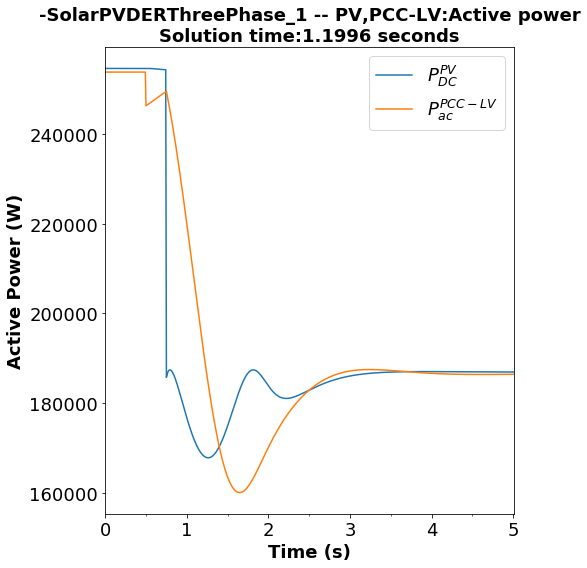

In [9]:
results1.PER_UNIT = False
results1.PLOT_TITLE = True
results1.font_size = 18
results1.plot_DER_simulation(plot_type='active_power_Ppv_Pac_PCC')#_Ppv_Pac_PCC

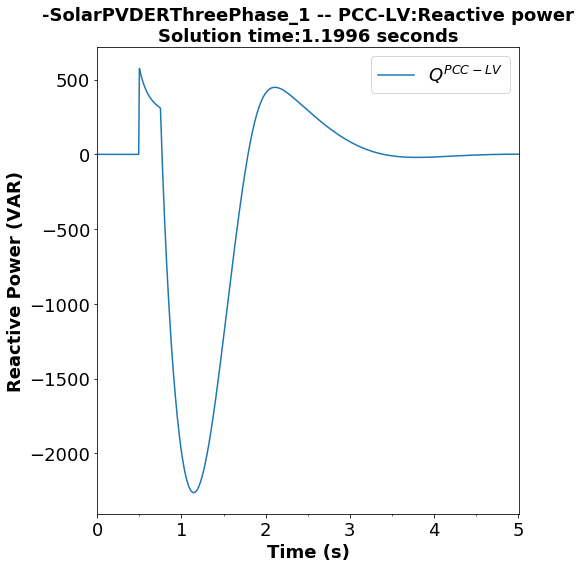

In [10]:
results1.plot_DER_simulation(plot_type='reactive_power_Q_PCC')#_Q_PCC

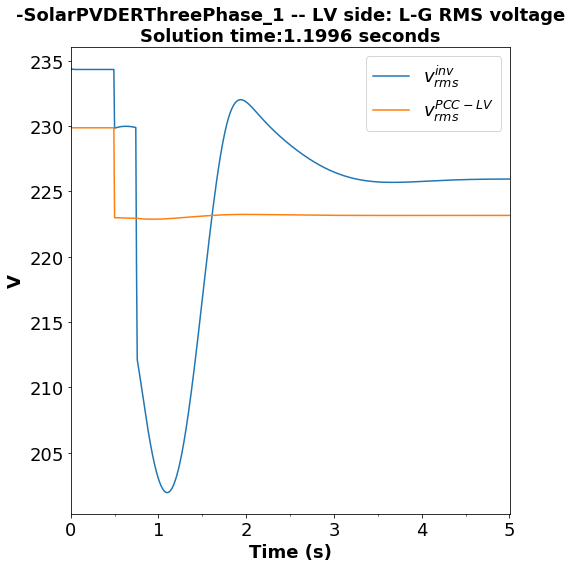

In [15]:
results1.plot_DER_simulation(plot_type='voltage_LV')

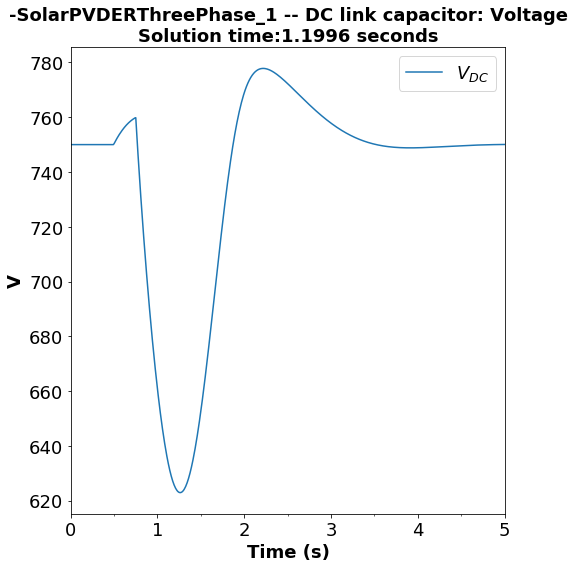

In [11]:
results1.plot_DER_simulation(plot_type='voltage_Vdc')

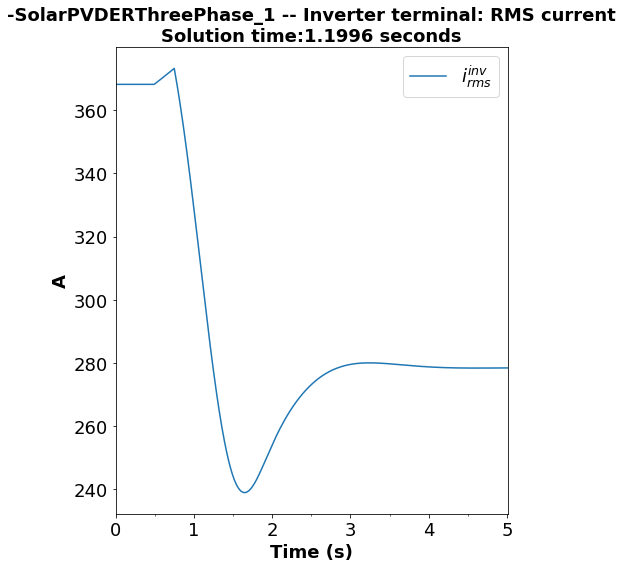

In [12]:
results1.plot_DER_simulation(plot_type='current')

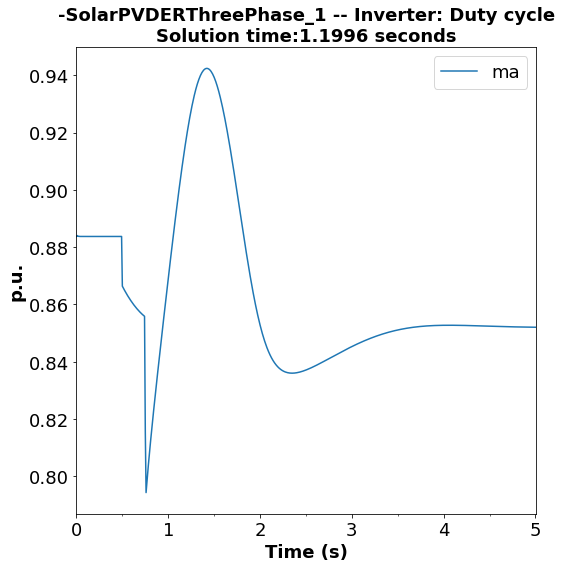

In [13]:
results1.plot_DER_simulation(plot_type='duty_cycle')

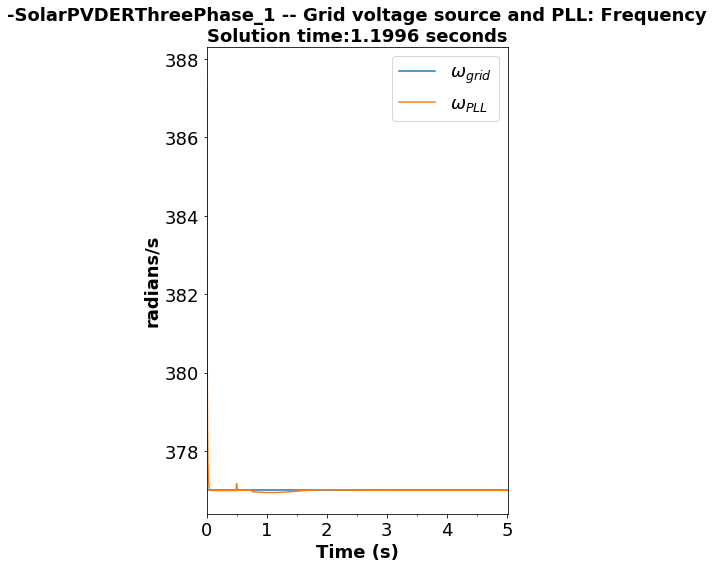

In [14]:
results1.plot_DER_simulation(plot_type='frequency')